In [1]:
%%bash
data_path=/content/drive/MyDrive/vkr/
cp -r $data_path/train_data .

In [2]:
# !pip install mapclassify
import geopandas as gpd
import folium

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import graphviz

from calendar import monthrange
import os, json, shutil

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers as rg
# import keras_tuner

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import scipy.stats as st
import scipy

from statsmodels.stats.outliers_influence import variance_inflation_factor

# from sklearn.preprocessing import MinMaxScaler


##### Upload data

In [3]:
data_path = "train_data/for_shap/data_and_models_in_work/data_and_models/"

with open(data_path + "train_ds.json") as f:
  train_data = json.load(f)
print("Train data keys:", train_data.keys())

X_train_l = train_data["x_train"]
y_train_l = train_data["y_train"]

with open(data_path + "test_ds.json") as f:
  test_data = json.load(f)
print("Test data keys:", test_data.keys())

X_test_l = test_data["x_test"]
y_test_l = test_data["y_test"]

X_train = np.array(X_train_l)
y_train = np.array(y_train_l)
X_test = np.array(X_test_l)
y_test = np.array(y_test_l)
print(f"Train data shape x: {X_train.shape}, y: {y_train.shape}")
print(f"Test data shape x: {X_test.shape}, y: {y_test.shape}")

Train data keys: dict_keys(['x_train', 'y_train', 'ordered_train_columns'])
Test data keys: dict_keys(['x_test', 'y_test', 'ordered_test_columns'])
Train data shape x: (15239, 101, 13), y: (15239, 1)
Test data shape x: (1303, 101, 13), y: (1303, 1)


##### Load model and evaluate the results

In [4]:
with open(data_path + "model_params.json") as f:
  model_params = json.load(f)
print("Model params", json.dumps(model_params, indent=4), sep="\n")

Model params
{
    "lstm_layers": 3,
    "l_rate": 0.001,
    "lstm_activity_l2_reg_": 0.01,
    "lstm_units": 32,
    "dense_layers": 2,
    "dense_units": 8,
    "drop_out_": 0.2,
    "b_size": 32,
    "val_split": 0.2,
    "epochs": 100
}


In [5]:
model = tf.keras.models.load_model(data_path + "/model.keras", compile=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 101, 32)        │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 101, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 101, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3232)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │        25,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,549 (568.55 KB)

 Trainable params: 48,505 (189.47 KB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 97,012 (378.96 KB)

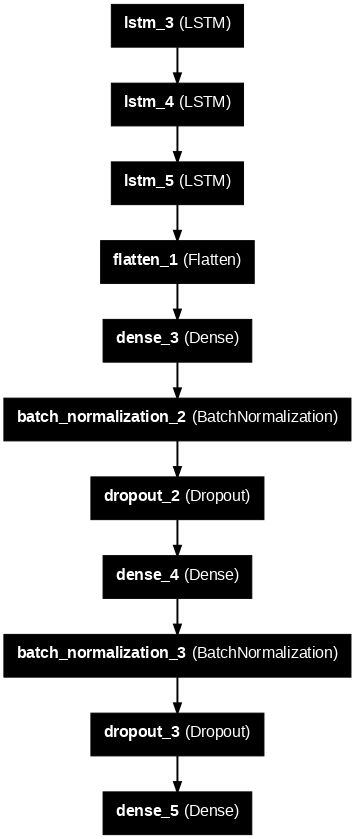

In [6]:
model.summary()
tf.keras.utils.plot_model(
    model=model, to_file="arch.png",
    # show_layer_activations=True, show_shapes=True,
    show_layer_names=True,
    dpi=70
)

In [7]:
# model.get_config()

In [8]:
print(model.evaluate(X_test, y_test))
model.metrics_names

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8181 - auc_1: 0.8801 - f1_score: 0.6970 - loss: 0.4777
[0.42720791697502136, 0.8380659818649292, 0.6751397848129272, 0.9054315686225891]


['loss', 'compile_metrics']

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
(1303, 1)
AUC score: 0.9054080170447046


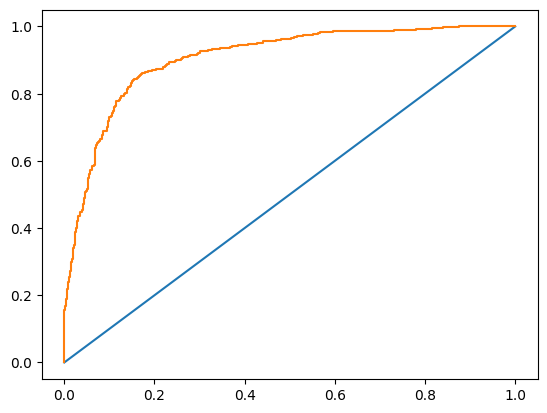

In [10]:
y_pred = model.predict(X_test)
print(y_pred.shape)
print("AUC score:", roc_auc_score(y_test, y_pred))
fpr, tpr, thresh = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)

In [11]:
import plotly.graph_objs as go

trace = go.Scatter(x=fpr, y=tpr, mode='lines', line=dict(color='darkorange', width=2), text=thresh)
reference_line = go.Scatter(x=[0,1], y=[0,1], mode='lines', name='Reference Line',
                            line=dict(color='navy', width=2, dash='dash'))
fig = go.Figure(data=[trace, reference_line])
fig.update_layout(title='Interactive ROC Curve',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate')
fig.show()

In [12]:
thresh_ = 0.5
y_pred_class = (y_pred > thresh_).astype(int)
print(y_pred_class.shape)
np.unique(y_pred_class)

(1303, 1)


array([0, 1])

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       639
           1       0.82      0.87      0.85       664

    accuracy                           0.84      1303
   macro avg       0.84      0.84      0.84      1303
weighted avg       0.84      0.84      0.84      1303



<Axes: >

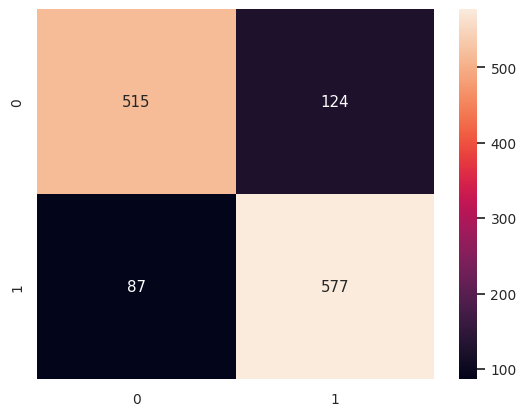

In [13]:
print(classification_report(y_true=y_test, y_pred=y_pred_class))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_class)
sns.set(font_scale=0.9)
sns.heatmap(cm, annot=True, fmt="g")